In [1]:
# if necessary, install NeuralGCM and dependencies
! pip install -q -U neuralgcm dinosaur-dycore gcsfs

# Forecasting quick start

This notebook uses ERA5 data and pretrained NeuralGCM model to make a weather forecast.

The forecast is made in 3 steps:
1. Slice of ERA5 data is regridded to model resolution
2. NeuralGCM model state is initialized and rolled out
3. Predictions and reference trajectory are combined for visualization

By default the notebook uses intermediate deterministic NeuralGCM 1.4° model. Other available checkpoints include deterministic 0.7°, 2.8° and stochastic 1.4° NeuralGCM variations.

```{tip}
You can run this notebook yourself in [Google Colab](https://colab.research.google.com/github/google-research/neuralgcm/blob/main/docs/inference_demo.ipynb). We recommend using a GPU or TPU runtime due to high memory and compute requirements.
```

In [2]:
import gcsfs
import jax
import numpy as np
import pickle
import xarray

from dinosaur import horizontal_interpolation
from dinosaur import spherical_harmonic
from dinosaur import xarray_utils
import neuralgcm

gcs = gcsfs.GCSFileSystem(token="anon")

## Load a pre-trained NeuralGCM model

```{caution}
Trained model weights are licensed for non-commercial use, under the Creative Commons [Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/) license (CC BY-NC-SA 4.0).
```

Pre-trained model checkpoints from the NeuralGCM paper are [available for download](https://console.cloud.google.com/storage/browser/gresearch/neuralgcm/04_30_2024) on Google Cloud Storage:

- Deterministic models:
    - `gs://gresearch/neuralgcm/04_30_2024/neural_gcm_dynamic_forcing_deterministic_0_7_deg.pkl`
    - `gs://gresearch/neuralgcm/04_30_2024/neural_gcm_dynamic_forcing_deterministic_1_4_deg.pkl`
    - `gs://gresearch/neuralgcm/04_30_2024/neural_gcm_dynamic_forcing_deterministic_2_8_deg.pkl`
- Stochastic models:
    - `gs://gresearch/neuralgcm/04_30_2024/neural_gcm_dynamic_forcing_stochastic_1_4_deg.pkl`



In [3]:
model_name = "neural_gcm_dynamic_forcing_deterministic_2_8_deg.pkl"  # @param ['neural_gcm_dynamic_forcing_deterministic_0_7_deg.pkl', 'neural_gcm_dynamic_forcing_deterministic_1_4_deg.pkl', 'neural_gcm_dynamic_forcing_deterministic_2_8_deg.pkl', 'neural_gcm_dynamic_forcing_stochastic_1_4_deg.pkl'] {type: "string"}

with gcs.open(f"gs://gresearch/neuralgcm/04_30_2024/{model_name}", "rb") as f:
    ckpt = pickle.load(f)

model = neuralgcm.PressureLevelModel.from_checkpoint(ckpt)

## Load ERA5 data from GCP/Zarr

See {doc}`datasets` for details.

Select out a few days of data:

In [4]:
era5_path = "gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3"
full_era5 = xarray.open_zarr(gcs.get_mapper(era5_path), chunks=None)

# https://en.wikipedia.org/wiki/October_2020_Arctic_blast_in_the_United_States
demo_start_time = "2020-10-23"
demo_end_time = "2020-10-28"
data_inner_steps = 24  # process every 24th hour

sliced_era5 = (
    full_era5[model.input_variables + model.forcing_variables]
    .pipe(
        xarray_utils.selective_temporal_shift,
        variables=model.forcing_variables,
        time_shift="24 hours",
    )
    .sel(time=slice(demo_start_time, demo_end_time, data_inner_steps))
    .compute()
)

Regrid to NeuralGCM's native resolution:

In [5]:
era5_grid = spherical_harmonic.Grid(
    latitude_nodes=full_era5.sizes["latitude"],
    longitude_nodes=full_era5.sizes["longitude"],
    latitude_spacing=xarray_utils.infer_latitude_spacing(full_era5.latitude),
    longitude_offset=xarray_utils.infer_longitude_offset(full_era5.longitude),
)
regridder = horizontal_interpolation.ConservativeRegridder(
    era5_grid, model.data_coords.horizontal, skipna=True
)
eval_era5 = xarray_utils.regrid(sliced_era5, regridder)
eval_era5 = xarray_utils.fill_nan_with_nearest(eval_era5)

## Make the forecast

See {doc}`trained_models` for details.

In [6]:
inner_steps = 24  # save model outputs once every 24 hours
outer_steps = 4 * 24 // inner_steps  # total of 4 days
timedelta = np.timedelta64(1, "h") * inner_steps
times = np.arange(outer_steps) * inner_steps  # time axis in hours

# initialize model state
inputs = model.inputs_from_xarray(eval_era5.isel(time=0))
input_forcings = model.forcings_from_xarray(eval_era5.isel(time=0))
rng_key = jax.random.key(42)  # optional for deterministic models
initial_state = model.encode(inputs, input_forcings, rng_key)

# use persistence for forcing variables (SST and sea ice cover)
all_forcings = model.forcings_from_xarray(eval_era5.head(time=1))

# make forecast
final_state, predictions = model.unroll(
    initial_state,
    all_forcings,
    steps=outer_steps,
    timedelta=timedelta,
    start_with_input=True,
)
predictions_ds = model.data_to_xarray(predictions, times=times)

## Compare forecast to ERA5

See [WeatherBench2](https://sites.research.google/weatherbench/) for more comprehensive evaluations and archived NeuralGCM forecasts.

In [ ]:
# error("Stop here.")

In [8]:
# Selecting ERA5 targets from exactly the same time slice
target_trajectory = model.inputs_from_xarray(
    eval_era5.thin(time=(inner_steps // data_inner_steps)).isel(time=slice(outer_steps))
)
target_data_ds = model.data_to_xarray(target_trajectory, times=times)

combined_ds = xarray.concat([target_data_ds, predictions_ds], "model")
combined_ds.coords["model"] = ["ERA5", "NeuralGCM"]

/opt/homebrew/Caskroom/miniforge/base/envs/neuralgcm-cpu/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:118: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


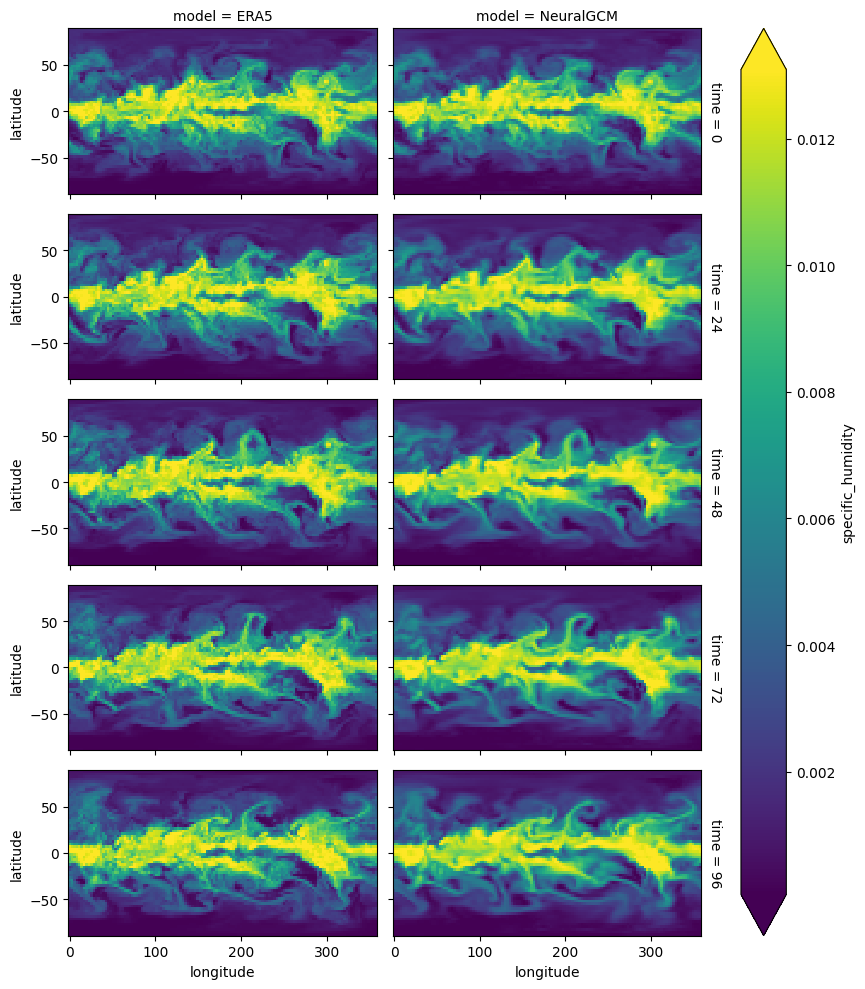

In [9]:
# Visualize ERA5 vs NeuralGCM trajectories
combined_ds.specific_humidity.sel(level=850).plot(
    x="longitude", y="latitude", row="time", col="model", robust=True, aspect=2, size=2
)

## Sensitivity to local perturbations

In [10]:
# options for variables to perturb
print(eval_era5.data_vars)

Data variables:
    geopotential                         (time, level, longitude, latitude) float32 7MB ...
    specific_humidity                    (time, level, longitude, latitude) float32 7MB ...
    temperature                          (time, level, longitude, latitude) float32 7MB ...
    u_component_of_wind                  (time, level, longitude, latitude) float32 7MB ...
    v_component_of_wind                  (time, level, longitude, latitude) float32 7MB ...
    specific_cloud_ice_water_content     (time, level, longitude, latitude) float32 7MB ...
    specific_cloud_liquid_water_content  (time, level, longitude, latitude) float32 7MB ...
    sea_ice_cover                        (time, longitude, latitude) float32 197kB ...
    sea_surface_temperature              (time, longitude, latitude) float32 197kB ...


In [11]:
"""
Performs perturbation analysis on a specified variable at a given atmospheric level.

** Note that the model replaces the ocean surface temperature with the SST from ERA5. **

Variables:
-----------
perturbation_list : tuple
    A tuple containing the perturbation magnitudes to be applied.
lev : int
    The atmospheric level (in hPa) at which the perturbation is applied.
delta_var : str
    The variable to be perturbed (e.g., "temperature").
modify_type : str
    The type of modification to be applied (e.g., "region" or "point").
lat_pt : float
    The latitude point for the perturbation.
lon_pt : float
    The longitude point for the perturbation.
region : ndarray
    A boolean array defining the region of interest based on latitude and longitude conditions.

Computed Indices:
-----------------
ilev : int
    The index of the closest atmospheric level to `lev`.
ilat : int
    The index of the closest latitude to `lat_pt`.
ilon : int
    The index of the closest longitude to `lon_pt`.
"""

perturbation_list = (0, -.01)  # in units of the variable you are modifying
lev = "column"  # pressure level in hPa or "column"
modify_type = "region"
delta_var = "specific_humidity"

lat_pt, lon_pt = 46.8721, 360-113.9940
region = (np.abs(eval_era5.latitude) < 90) & (eval_era5.longitude < 0)
# ------------------------------------------------------------

if lev == "column":
    ilev = np.arange(eval_era5["level"].size)
else:
    ilev = np.argmin(np.abs(eval_era5["level"].values - lev)).item()
ilat = np.argmin(np.abs(eval_era5["latitude"].values - lat_pt))
ilon = np.argmin(np.abs(eval_era5["longitude"].values - lon_pt))

print(f"Perturbation being added to {delta_var} at level {lev} hPa")

Perturbation being added to specific_humidity at level column hPa


In [18]:
np.shape(mod_data)

(37, 128, 64)

In [12]:
import time

predictions_dict = {}

for perturbation in perturbation_list:
    print(f"Running perturbation delta_{perturbation}")

    start_time = time.time()

    # get inputs and add perturbation to field
    inputs = model.inputs_from_xarray(eval_era5.isel(time=0))
    if modify_type == "region":
        mod_data = np.where(
            ~region.T,
            inputs[delta_var][ilev, ...],
            inputs[delta_var][ilev, ...] + perturbation,
        )
        inputs[delta_var][ilev, ...] = np.clip(mod_data, a_min=0, a_max=None)
    elif modify_type == "point":
        inputs[delta_var][ilev, ilon, ilat] = np.clip(
            inputs[delta_var][ilev, ilon, ilat] + perturbation, a_min=0, a_max=None
        )
    else:
        raise ValueError("modify_type must be either 'region' or 'point'")

    # define the time steps and output frequency
    inner_steps = 24  # save model outputs once every 24 hours
    outer_steps = 5 * 24 // inner_steps  # number of days
    timedelta = np.timedelta64(1, "h") * inner_steps
    times = np.arange(outer_steps) * inner_steps  # time axis in hours

    # initialize model state
    input_forcings = model.forcings_from_xarray(eval_era5.isel(time=0))
    rng_key = jax.random.key(42)  # optional for deterministic models
    initial_state = model.encode(inputs, input_forcings, rng_key)

    # use persistence for forcing variables (SST and sea ice cover)
    all_forcings = model.forcings_from_xarray(eval_era5.head(time=1))

    # make forecast
    final_state, predictions = model.unroll(
        initial_state,
        all_forcings,
        steps=outer_steps,
        timedelta=timedelta,
        start_with_input=True,
    )

    predictions_dict[f"delta_{perturbation}"] = (
        model.data_to_xarray(predictions, times=times)
        .sel(level=[1000, 850, 500])
        .load()
    )

    print(f"   elapsed time: {time.time() - start_time:.2f} seconds")

Running perturbation delta_0
   elapsed time: 192.69 seconds
Running perturbation delta_-0.01
   elapsed time: 184.87 seconds


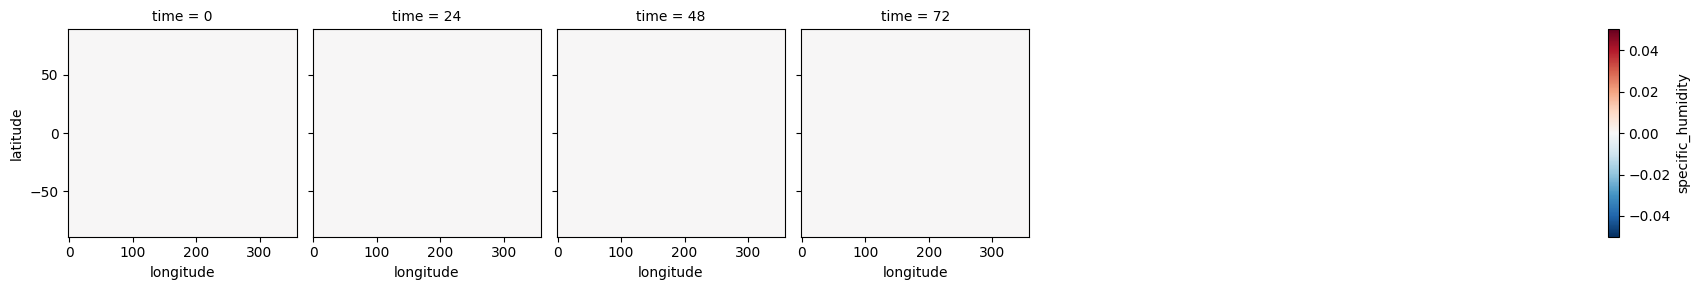

In [15]:
var = "specific_humidity"
level = 1000

diff_ds = predictions_dict["delta_-0.01"][var].sel(level=level) - predictions_dict["delta_0"][var].sel(level=level)
diff_ds.plot(x="longitude", y="latitude", col="time", col_wrap=6, robust=True, cmap="RdBu_r")

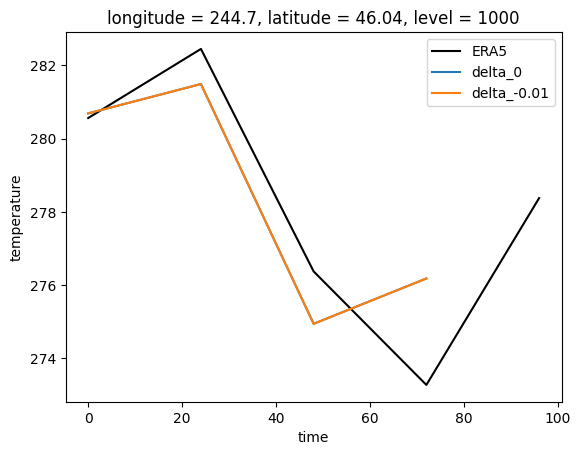

In [14]:
import matplotlib.pyplot as plt

var = "temperature"
level = 1000

combined_ds.temperature.sel(model="ERA5").sel(level=1000, latitude=46.8721, longitude=360-113.9940, method="nearest").plot.line(x="time", color="k")
predictions_dict["delta_0"][var].sel(level=level, latitude=lat_pt, longitude=lon_pt, method="nearest").plot.line(x="time")
predictions_dict["delta_-0.01"][var].sel(level=level, latitude=lat_pt, longitude=lon_pt, method="nearest").plot.line(x="time")
plt.legend(["ERA5", "delta_0", "delta_-0.01"])

plt.show()